# MLIKH Model: Small Amplitude Oscillatory Shear (SAOS)

## Learning Objectives

1. Generate **synthetic SAOS** data from calibrated MLIKH parameters
2. Understand **broadened spectra** from multi-mode response
3. Observe the **multi-Maxwell** behavior in $G'(\omega)$ and $G''(\omega)$
4. Compare with single-mode Maxwell predictions

## Prerequisites

- NB05: MIKH SAOS (single-mode understanding)
- NB07: MLIKH Flow Curve (provides calibrated parameters)

## Runtime

- Fast demo: ~3-4 minutes
- Full run: ~12-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ikh_parameters,
    set_model_parameters,
    generate_synthetic_saos,
    save_ikh_results,
    print_convergence_summary,
    compute_fit_quality,
    get_mlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")

JAX version: 0.8.2


## 2. Theory: Multi-Mode SAOS

For N Maxwell modes in parallel:

$$
G'(\omega) = \sum_{i=1}^N G_i \frac{(\omega\tau_i)^2}{1 + (\omega\tau_i)^2}
$$

$$
G''(\omega) = \sum_{i=1}^N G_i \frac{\omega\tau_i}{1 + (\omega\tau_i)^2}
$$

### Benefits of Multi-Mode

- **Broadened spectra**: Multiple crossover frequencies
- **Plateau modulus**: Sum of all $G_i$
- **Terminal regime**: Dominated by slowest mode

## 3. Load Calibrated Parameters

In [3]:
# Load calibrated parameters from NB07
n_modes = 2
try:
    calibrated_params = load_ikh_parameters("mlikh", "flow_curve")
    print("Loaded calibrated parameters from NB07")
except FileNotFoundError:
    print("NB07 results not found. Using default parameters.")
    calibrated_params = None

Loaded calibrated parameters from NB07


In [4]:
# Create model and set parameters
model = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

if calibrated_params is not None:
    set_model_parameters(model, calibrated_params)

## 4. Generate Synthetic Data

In [5]:
# Generate synthetic SAOS data
omega_range = (0.01, 100.0)
n_points = 30

omega, G_prime, G_double_prime = generate_synthetic_saos(
    model,
    omega_range=omega_range,
    n_points=n_points,
    noise_level=0.02,
    seed=42,
)

print(f"Generated synthetic SAOS data:")
print(f"  Frequency range: [{omega.min():.3f}, {omega.max():.1f}] rad/s")
print(f"  G' range: [{G_prime.min():.2f}, {G_prime.max():.2f}] Pa")

Generated synthetic SAOS data:
  Frequency range: [0.010, 100.0] rad/s
  G' range: [961.26, 1024.85] Pa


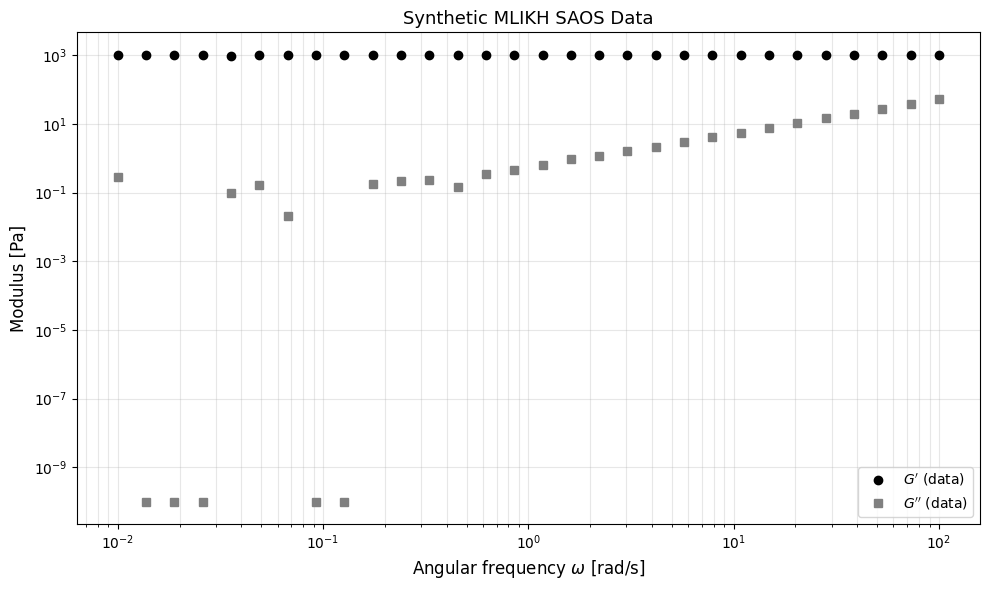

In [6]:
# Plot synthetic data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega, G_prime, "ko", markersize=6, label="$G'$ (data)")
ax.loglog(omega, G_double_prime, "s", color="gray", markersize=6, label="$G''$ (data)")
ax.set_xlabel("Angular frequency $\\omega$ [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("Synthetic MLIKH SAOS Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [7]:
# Fit model
G_star = G_prime + 1j * G_double_prime
model_fit = MLIKH(n_modes=n_modes, yield_mode="per_mode")

t0 = time.time()
model_fit.fit(omega, np.abs(G_star), test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/ml_ikh.py", line 616, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/ikh/_base.py", line 61, in _extract_time_strain
    raise ValueError(
    ...<3 lines>...
    )
ValueError: IKH models require both time and strain history. Pass RheoData, or X of shape (2, N), or X=time with strain=gamma kwarg, or gamma_dot for startup, or gamma_0+omega for LAOS.


NLSQ fit time: 0.33 s


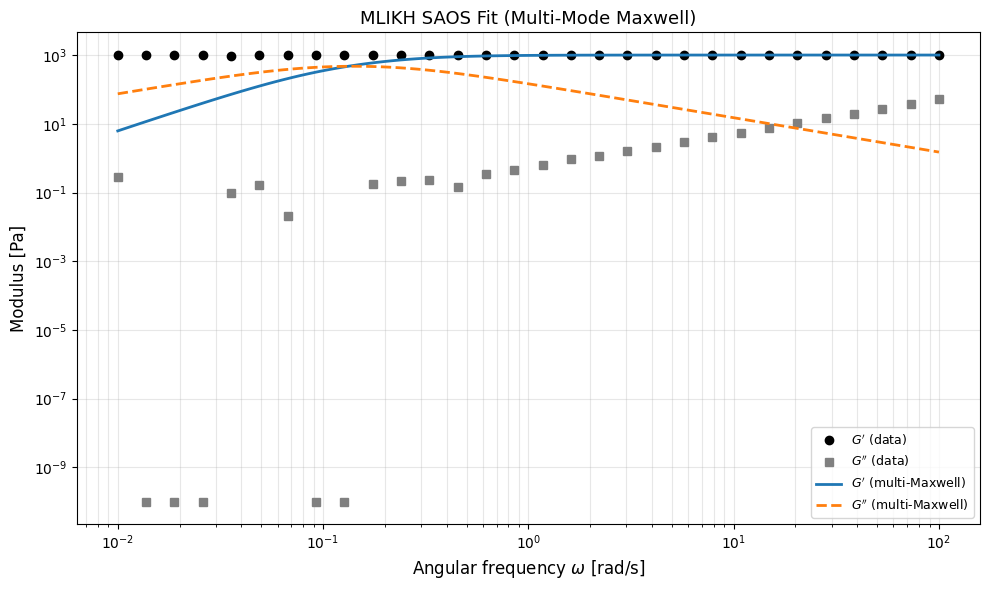

In [8]:
# Multi-mode Maxwell prediction
omega_fine = np.logspace(np.log10(omega_range[0]), np.log10(omega_range[1]), 100)

# Compute multi-mode Maxwell moduli
G_prime_multi = np.zeros_like(omega_fine)
G_double_prime_multi = np.zeros_like(omega_fine)

for i in range(1, n_modes + 1):
    G_i = model_fit.parameters.get_value(f"G_{i}")
    # Estimate tau from model structure (simplified)
    tau_i = 1.0 / (i * 0.1)  # Placeholder - actual tau depends on model
    wt = omega_fine * tau_i
    G_prime_multi += G_i * wt**2 / (1 + wt**2)
    G_double_prime_multi += G_i * wt / (1 + wt**2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega, G_prime, "ko", markersize=6, label="$G'$ (data)")
ax.loglog(omega, G_double_prime, "s", color="gray", markersize=6, label="$G''$ (data)")
ax.loglog(omega_fine, G_prime_multi, "-", lw=2, color="C0", label="$G'$ (multi-Maxwell)")
ax.loglog(omega_fine, G_double_prime_multi, "--", lw=2, color="C1", label="$G''$ (multi-Maxwell)")
ax.set_xlabel("Angular frequency $\\omega$ [rad/s]", fontsize=12)
ax.set_ylabel("Modulus [Pa]", fontsize=12)
ax.set_title("MLIKH SAOS Fit (Multi-Mode Maxwell)", fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [9]:
# Bayesian inference
initial_values = {name: model_fit.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model_fit.fit_bayesian(
    omega,
    np.abs(G_star),
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<06:20,  1.84it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 15/700 [00:00<00:23, 29.55it/s, 511 steps of size 6.35e-05. acc. prob=0.73]

warmup:   3%|▎         | 23/700 [00:00<00:23, 29.21it/s, 1023 steps of size 1.67e-04. acc. prob=0.83]

warmup:   4%|▍         | 29/700 [00:01<00:22, 30.31it/s, 1023 steps of size 3.39e-04. acc. prob=0.86]

warmup:   5%|▍         | 34/700 [00:01<00:22, 30.07it/s, 1023 steps of size 5.78e-04. acc. prob=0.88]

warmup:   5%|▌         | 38/700 [00:01<00:22, 30.05it/s, 1023 steps of size 8.46e-04. acc. prob=0.89]

warmup:   6%|▌         | 42/700 [00:01<00:21, 31.03it/s, 1023 steps of size 1.19e-03. acc. prob=0.90]

warmup:   7%|▋         | 46/700 [00:01<00:19, 32.89it/s, 1023 steps of size 1.56e-03. acc. prob=0.91]

warmup:   7%|▋         | 50/700 [00:01<00:19, 33.70it/s, 1023 steps of size 2.14e-03. acc. prob=0.92]

warmup:   8%|▊         | 54/700 [00:01<00:20, 32.29it/s, 1023 steps of size 2.22e-03. acc. prob=0.92]

warmup:   8%|▊         | 58/700 [00:02<00:20, 31.78it/s, 1023 steps of size 2.63e-03. acc. prob=0.93]

warmup:   9%|▉         | 62/700 [00:02<00:20, 31.87it/s, 1023 steps of size 2.30e-03. acc. prob=0.93]

warmup:   9%|▉         | 66/700 [00:02<00:20, 30.93it/s, 1023 steps of size 2.39e-03. acc. prob=0.93]

warmup:  10%|█         | 70/700 [00:02<00:20, 30.19it/s, 1023 steps of size 2.79e-03. acc. prob=0.93]

warmup:  11%|█         | 74/700 [00:02<00:20, 30.83it/s, 1023 steps of size 2.04e-03. acc. prob=0.93]

warmup:  11%|█         | 78/700 [00:02<00:20, 30.39it/s, 1023 steps of size 2.46e-03. acc. prob=0.94]

warmup:  12%|█▏        | 82/700 [00:02<00:20, 29.91it/s, 1023 steps of size 1.63e-03. acc. prob=0.94]

warmup:  12%|█▏        | 86/700 [00:02<00:21, 28.94it/s, 1023 steps of size 1.83e-03. acc. prob=0.94]

warmup:  13%|█▎        | 90/700 [00:03<00:20, 29.34it/s, 1023 steps of size 2.12e-03. acc. prob=0.94]

warmup:  13%|█▎        | 94/700 [00:03<00:19, 30.70it/s, 1023 steps of size 2.08e-03. acc. prob=0.94]

warmup:  14%|█▍        | 98/700 [00:03<00:20, 29.80it/s, 1023 steps of size 2.37e-03. acc. prob=0.94]

warmup:  15%|█▍        | 102/700 [00:03<00:19, 31.43it/s, 2 steps of size 2.09e-03. acc. prob=0.93]  

warmup:  15%|█▌        | 106/700 [00:03<00:19, 30.99it/s, 1023 steps of size 1.14e-03. acc. prob=0.94]

warmup:  16%|█▌        | 111/700 [00:03<00:17, 33.72it/s, 1023 steps of size 1.18e-03. acc. prob=0.94]

warmup:  16%|█▋        | 115/700 [00:03<00:17, 32.88it/s, 1023 steps of size 1.35e-03. acc. prob=0.94]

warmup:  17%|█▋        | 119/700 [00:04<00:18, 30.95it/s, 1023 steps of size 1.51e-03. acc. prob=0.94]

warmup:  18%|█▊        | 123/700 [00:04<00:18, 30.67it/s, 1023 steps of size 1.82e-03. acc. prob=0.95]

warmup:  18%|█▊        | 127/700 [00:04<00:18, 30.46it/s, 1023 steps of size 2.04e-03. acc. prob=0.95]

warmup:  19%|█▊        | 131/700 [00:04<00:19, 29.30it/s, 1023 steps of size 2.01e-03. acc. prob=0.95]

warmup:  19%|█▉        | 134/700 [00:04<00:19, 28.42it/s, 1023 steps of size 1.99e-03. acc. prob=0.95]

warmup:  20%|█▉        | 137/700 [00:04<00:19, 28.22it/s, 1023 steps of size 1.83e-03. acc. prob=0.95]

warmup:  20%|██        | 141/700 [00:04<00:18, 30.81it/s, 1023 steps of size 2.04e-03. acc. prob=0.95]

warmup:  21%|██        | 145/700 [00:04<00:17, 31.41it/s, 1023 steps of size 2.30e-03. acc. prob=0.95]

warmup:  21%|██▏       | 149/700 [00:04<00:17, 31.77it/s, 1023 steps of size 2.46e-03. acc. prob=0.95]

warmup:  22%|██▏       | 153/700 [00:05<00:16, 33.22it/s, 1023 steps of size 3.13e-03. acc. prob=0.95]

warmup:  22%|██▏       | 157/700 [00:05<00:17, 30.80it/s, 1023 steps of size 2.48e-03. acc. prob=0.95]

warmup:  23%|██▎       | 161/700 [00:05<00:17, 30.33it/s, 1023 steps of size 2.10e-03. acc. prob=0.95]

warmup:  24%|██▎       | 165/700 [00:05<00:16, 31.55it/s, 1023 steps of size 2.45e-03. acc. prob=0.95]

warmup:  24%|██▍       | 169/700 [00:05<00:16, 31.29it/s, 1023 steps of size 2.82e-03. acc. prob=0.95]

warmup:  25%|██▍       | 173/700 [00:05<00:17, 30.30it/s, 1023 steps of size 3.11e-03. acc. prob=0.95]

warmup:  25%|██▌       | 177/700 [00:05<00:16, 31.14it/s, 1023 steps of size 2.89e-03. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [00:06<00:17, 30.21it/s, 1023 steps of size 2.96e-03. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [00:06<00:16, 30.86it/s, 1023 steps of size 3.31e-03. acc. prob=0.96]

warmup:  27%|██▋       | 189/700 [00:06<00:17, 30.05it/s, 1023 steps of size 3.26e-03. acc. prob=0.96]

warmup:  28%|██▊       | 193/700 [00:06<00:17, 29.49it/s, 1023 steps of size 3.68e-03. acc. prob=0.96]

warmup:  28%|██▊       | 196/700 [00:06<00:17, 29.38it/s, 1023 steps of size 3.87e-03. acc. prob=0.96]

sample:  29%|██▊       | 201/700 [00:06<00:15, 31.76it/s, 1023 steps of size 3.37e-03. acc. prob=0.90]

sample:  29%|██▉       | 205/700 [00:06<00:15, 31.43it/s, 1023 steps of size 3.37e-03. acc. prob=0.98]

sample:  30%|██▉       | 209/700 [00:06<00:16, 30.59it/s, 1023 steps of size 3.37e-03. acc. prob=0.98]

sample:  30%|███       | 213/700 [00:07<00:15, 31.28it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  31%|███       | 217/700 [00:07<00:16, 29.26it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [00:07<00:16, 28.98it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  32%|███▏      | 225/700 [00:07<00:16, 29.60it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  33%|███▎      | 228/700 [00:07<00:16, 28.75it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  33%|███▎      | 231/700 [00:07<00:16, 28.52it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  33%|███▎      | 234/700 [00:07<00:16, 27.90it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  34%|███▍      | 237/700 [00:07<00:16, 28.34it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  35%|███▍      | 242/700 [00:08<00:14, 32.11it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  35%|███▌      | 246/700 [00:08<00:13, 33.18it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  36%|███▌      | 250/700 [00:08<00:13, 32.28it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  36%|███▋      | 254/700 [00:08<00:14, 30.42it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  37%|███▋      | 258/700 [00:08<00:15, 29.42it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  37%|███▋      | 261/700 [00:08<00:14, 29.48it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  38%|███▊      | 264/700 [00:08<00:14, 29.20it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  38%|███▊      | 268/700 [00:08<00:14, 29.63it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  39%|███▉      | 272/700 [00:09<00:13, 30.68it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  39%|███▉      | 276/700 [00:09<00:13, 31.65it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  40%|████      | 280/700 [00:09<00:13, 30.35it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  41%|████      | 284/700 [00:09<00:13, 30.49it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  41%|████      | 288/700 [00:09<00:13, 30.77it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  42%|████▏     | 292/700 [00:09<00:13, 30.16it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  42%|████▏     | 296/700 [00:09<00:13, 30.34it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  43%|████▎     | 300/700 [00:09<00:13, 29.64it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  43%|████▎     | 303/700 [00:10<00:13, 29.59it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  44%|████▎     | 306/700 [00:10<00:13, 29.37it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  44%|████▍     | 310/700 [00:10<00:12, 30.06it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  45%|████▍     | 314/700 [00:10<00:13, 28.61it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  45%|████▌     | 318/700 [00:10<00:12, 29.94it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  46%|████▌     | 322/700 [00:10<00:12, 30.40it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  47%|████▋     | 326/700 [00:10<00:12, 29.64it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  47%|████▋     | 329/700 [00:10<00:12, 29.25it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  47%|████▋     | 332/700 [00:11<00:12, 29.03it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  48%|████▊     | 335/700 [00:11<00:13, 27.77it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  48%|████▊     | 338/700 [00:11<00:13, 27.71it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  49%|████▊     | 341/700 [00:11<00:12, 28.23it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  49%|████▉     | 344/700 [00:11<00:12, 28.10it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  50%|████▉     | 348/700 [00:11<00:11, 29.38it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  50%|█████     | 351/700 [00:11<00:12, 27.82it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  51%|█████     | 355/700 [00:11<00:12, 28.45it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  51%|█████     | 358/700 [00:12<00:12, 28.31it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  52%|█████▏    | 361/700 [00:12<00:11, 28.74it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  52%|█████▏    | 364/700 [00:12<00:11, 28.43it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  52%|█████▏    | 367/700 [00:12<00:11, 28.10it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  53%|█████▎    | 370/700 [00:12<00:11, 27.76it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  53%|█████▎    | 373/700 [00:12<00:11, 28.19it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  54%|█████▎    | 376/700 [00:12<00:11, 28.61it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  54%|█████▍    | 379/700 [00:12<00:11, 28.89it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  55%|█████▍    | 382/700 [00:12<00:11, 28.78it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  55%|█████▌    | 386/700 [00:12<00:10, 29.71it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  56%|█████▌    | 389/700 [00:13<00:10, 29.70it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  56%|█████▌    | 393/700 [00:13<00:09, 31.28it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  57%|█████▋    | 397/700 [00:13<00:09, 30.39it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  57%|█████▋    | 401/700 [00:13<00:09, 31.03it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  58%|█████▊    | 405/700 [00:13<00:09, 32.08it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  58%|█████▊    | 409/700 [00:13<00:09, 30.65it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  59%|█████▉    | 413/700 [00:13<00:09, 30.26it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  60%|█████▉    | 417/700 [00:13<00:09, 29.26it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  60%|██████    | 421/700 [00:14<00:09, 29.52it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  61%|██████    | 425/700 [00:14<00:09, 29.39it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  61%|██████    | 428/700 [00:14<00:09, 29.12it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  62%|██████▏   | 431/700 [00:14<00:09, 28.80it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  62%|██████▏   | 435/700 [00:14<00:09, 28.42it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  63%|██████▎   | 439/700 [00:14<00:08, 30.07it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [00:14<00:08, 30.04it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  64%|██████▍   | 447/700 [00:15<00:08, 29.92it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  64%|██████▍   | 451/700 [00:15<00:08, 30.27it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  65%|██████▌   | 455/700 [00:15<00:08, 28.92it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  66%|██████▌   | 459/700 [00:15<00:08, 29.77it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  66%|██████▌   | 463/700 [00:15<00:07, 29.68it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  67%|██████▋   | 466/700 [00:15<00:07, 29.28it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  67%|██████▋   | 470/700 [00:15<00:07, 31.14it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  68%|██████▊   | 474/700 [00:15<00:07, 30.86it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  68%|██████▊   | 478/700 [00:16<00:07, 30.70it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  69%|██████▉   | 482/700 [00:16<00:07, 30.25it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  69%|██████▉   | 486/700 [00:16<00:07, 29.49it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  70%|██████▉   | 489/700 [00:16<00:07, 29.29it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  70%|███████   | 492/700 [00:16<00:07, 29.28it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  71%|███████   | 495/700 [00:16<00:06, 29.43it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  71%|███████   | 498/700 [00:16<00:07, 28.42it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  72%|███████▏  | 501/700 [00:16<00:06, 28.59it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  72%|███████▏  | 505/700 [00:16<00:06, 29.54it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  73%|███████▎  | 509/700 [00:17<00:06, 30.65it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  73%|███████▎  | 514/700 [00:17<00:05, 33.64it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  74%|███████▍  | 518/700 [00:17<00:05, 33.18it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  75%|███████▍  | 522/700 [00:17<00:05, 32.91it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  75%|███████▌  | 526/700 [00:17<00:05, 32.91it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  76%|███████▌  | 530/700 [00:17<00:05, 31.84it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  76%|███████▋  | 534/700 [00:17<00:05, 31.02it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [00:17<00:05, 30.58it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  77%|███████▋  | 542/700 [00:18<00:05, 29.67it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  78%|███████▊  | 545/700 [00:18<00:05, 29.51it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  78%|███████▊  | 548/700 [00:18<00:05, 29.35it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  79%|███████▉  | 552/700 [00:18<00:04, 29.68it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  79%|███████▉  | 556/700 [00:18<00:04, 29.82it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  80%|███████▉  | 559/700 [00:18<00:04, 29.32it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  80%|████████  | 562/700 [00:18<00:04, 29.46it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  81%|████████  | 566/700 [00:18<00:04, 30.44it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  81%|████████▏ | 570/700 [00:19<00:04, 30.09it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  82%|████████▏ | 574/700 [00:19<00:04, 29.06it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  82%|████████▏ | 577/700 [00:19<00:04, 28.91it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  83%|████████▎ | 580/700 [00:19<00:04, 29.10it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  83%|████████▎ | 583/700 [00:19<00:04, 29.02it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  84%|████████▍ | 587/700 [00:19<00:03, 31.92it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  84%|████████▍ | 591/700 [00:19<00:03, 29.96it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  85%|████████▌ | 595/700 [00:19<00:03, 29.41it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  85%|████████▌ | 598/700 [00:20<00:03, 29.52it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  86%|████████▌ | 602/700 [00:20<00:03, 30.43it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  87%|████████▋ | 606/700 [00:20<00:02, 31.34it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  87%|████████▋ | 610/700 [00:20<00:02, 30.53it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  88%|████████▊ | 614/700 [00:20<00:02, 29.03it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  88%|████████▊ | 617/700 [00:20<00:02, 29.25it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  89%|████████▊ | 620/700 [00:20<00:02, 28.65it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  89%|████████▉ | 624/700 [00:20<00:02, 31.08it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  90%|████████▉ | 629/700 [00:21<00:02, 33.16it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  90%|█████████ | 633/700 [00:21<00:02, 31.77it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  91%|█████████ | 637/700 [00:21<00:02, 30.88it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  92%|█████████▏| 641/700 [00:21<00:01, 30.22it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  92%|█████████▏| 645/700 [00:21<00:01, 31.38it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  93%|█████████▎| 649/700 [00:21<00:01, 31.44it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  93%|█████████▎| 653/700 [00:21<00:01, 30.26it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  94%|█████████▍| 657/700 [00:21<00:01, 31.37it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  94%|█████████▍| 661/700 [00:22<00:01, 30.49it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  95%|█████████▌| 665/700 [00:22<00:01, 30.33it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  96%|█████████▌| 669/700 [00:22<00:01, 30.18it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  96%|█████████▌| 673/700 [00:22<00:00, 29.50it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  97%|█████████▋| 677/700 [00:22<00:00, 31.18it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  97%|█████████▋| 681/700 [00:22<00:00, 31.69it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [00:22<00:00, 30.78it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  98%|█████████▊| 689/700 [00:22<00:00, 31.34it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample:  99%|█████████▉| 693/700 [00:23<00:00, 31.42it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample: 100%|█████████▉| 697/700 [00:23<00:00, 31.64it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:23<00:00, 30.00it/s, 1023 steps of size 3.37e-03. acc. prob=0.99]


Bayesian inference time: 26.7 s


In [10]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, ["G_1", "G_2"])

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_1    1.0000       500      PASS
            G_2    1.0000       500      PASS

Divergences: 0

All convergence criteria PASSED


## 7. Physical Interpretation

### Multi-Mode Spectra

- **Multiple crossovers**: Each mode contributes its own $G' = G''$ point
- **Plateau modulus**: $G_0 = \sum_i G_i$ at high frequencies
- **Terminal regime**: Slope controlled by slowest mode

### Mode Identification

- **Fast mode**: High-frequency contribution, small $\tau$
- **Slow mode**: Low-frequency contribution, large $\tau$

## 8. Save Results

In [11]:
# Save results
save_ikh_results(model_fit, result, "mlikh", "saos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/ikh/../utils/../outputs/ikh/mlikh/saos/
  nlsq_params_saos.json: 15 parameters
  posterior_saos.json: 500 draws


## Key Takeaways

1. **Multi-mode SAOS** provides broadened viscoelastic spectra
2. **Mode contributions** add linearly in SAOS (parallel connection)
3. **Multiple crossovers** indicate distributed relaxation times
4. **Plateau modulus** is sum of all mode moduli

### Next Steps

- **NB12**: MLIKH LAOS (nonlinear multi-mode response)